# Less features, random Forest

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("dataset-clean-withNAs.csv")

In [3]:
features = [
    'Leukocytes',
    'Monocytes',
    'Platelets',
    'Patient age quantile',
]

df_clean = df[features + ["SARS-Cov-2 exam result"]]

print(df_clean.shape)

(5644, 5)


In [4]:
df_clean = df_clean.dropna()

In [5]:
X = df_clean.drop("SARS-Cov-2 exam result", axis=1)
y = df_clean["SARS-Cov-2 exam result"]

In [6]:
# scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit_transform(df)

array([[0.00000000e+00, 6.84210526e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.77210704e-04, 8.94736842e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.54421407e-04, 4.21052632e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.99645579e-01, 2.10526316e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.99822789e-01, 5.26315789e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(y_train.value_counts())
print(y_test.value_counts())

0    411
1     69
Name: SARS-Cov-2 exam result, dtype: int64
0    107
1     14
Name: SARS-Cov-2 exam result, dtype: int64


In [8]:
def _extract_feature_importance(model, features):
    if not hasattr(model, "coef_") and not hasattr(model, "feature_importances_"):
        raise Exception("Not possible to collect feature importances")

    if hasattr(model, "coef_"):
        model_feature_importances = model.coef_[0]
    elif hasattr(model, "feature_importances_"):
        model_feature_importances = model.feature_importances_

    return [
        (feature, importance)
        for feature, importance in sorted(
            zip(features, model_feature_importances),
            key=lambda pair: pair[1],
            reverse=True,
        )
    ]

def run_single(X_train, y_train, X_test, y_test, which_model):

    model = which_model["model"]
    
    model.fit(X_train, y_train)

    # let us just print the performance on the train set
    predictions_train = model.predict(X_train)
    train_results = {
        "prec": precision_score(y_train, predictions_train),
        "rec": recall_score(y_train, predictions_train),
        "roc": roc_auc_score(y_train, predictions_train),
    }
    cm_train = confusion_matrix(y_train, predictions_train)
    
    # in the test set
    predictions_test = model.predict(X_test)
    test_results = {
        "prec": precision_score(y_test, predictions_test),
        "rec": recall_score(y_test, predictions_test),
        "roc": roc_auc_score(y_test, predictions_test),
    }

    cm_test = confusion_matrix(y_test, predictions_test)
    
    # feature importance
    feature_importance = _extract_feature_importance(model, X_train.columns.values)
    
    return {
        "test_results": test_results, 
        "train_results": train_results, 
        "test_cm" : cm_test,
        "train_cm" : cm_train,
        "feature_importance": feature_importance,
        "y_pred": predictions_test
    }



def run_cv(X_train, y_train, X_test, y_test, which_model):

    K_FOLD_ITERATIONS = 10

    search = GridSearchCV(
        which_model["model"], 
        which_model["params_to_tune"], 
        scoring=["precision", "recall", "roc_auc"],
        refit="roc_auc",
        cv=StratifiedKFold(
            n_splits=K_FOLD_ITERATIONS, 
            shuffle=True),  
        n_jobs=-1)
    
    search.fit(X_train, y_train)
    
    model = search.best_estimator_

    # let us just print the performance on the train set
    predictions_train = model.predict(X_train)
    train_results = {
        "prec": precision_score(y_train, predictions_train),
        "rec": recall_score(y_train, predictions_train),
        "roc": roc_auc_score(y_train, predictions_train),
    }
    cm_train = confusion_matrix(y_train, predictions_train)
    
    # in the test set
    predictions_test = model.predict(X_test)
    test_results = {
        "prec": precision_score(y_test, predictions_test),
        "rec": recall_score(y_test, predictions_test),
        "roc": roc_auc_score(y_test, predictions_test),
    }

    cm_test = confusion_matrix(y_test, predictions_test)
    
    # feature importance
    feature_importance = _extract_feature_importance(model, X_train.columns.values)
    
    return {
        "test_results": test_results, 
        "train_results": train_results, 
        "test_cm" : cm_test,
        "train_cm" : cm_train,
        "feature_importance": feature_importance,
        "y_pred": predictions_test
    }


from sklearn.metrics import classification_report

def print_result(result, fi=True):
    print("Results in the training set")
    print(result["train_results"])
    print(result["train_cm"])
    print("Results in the test set")
    print(result["test_results"])
    print(result["test_cm"])
    
    print("Report:")
    print(classification_report(y_test,result["y_pred"]))
    
    if fi:
        print("Feature importances")
        pd_fi = pd.DataFrame(result["feature_importance"], columns=["feature", "importance"])
        pd_fi = pd_fi[(pd_fi.importance > 0.01)]

        p = plt.barh(pd_fi["feature"], pd_fi["importance"])
        print(p)    

In [9]:
rf_model = {
    "model": RandomForestClassifier(random_state=42),
    "params_to_tune": {
        "max_depth": [3, 6, 12, 24, None],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_split": [2, 3, 4, 5, 10],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"],
        "n_estimators": [10, 50, 100, 150, 200]
    }
}

In [10]:
result = run_single(X_train, y_train, X_test, y_test, rf_model)

Results in the training set
{'prec': 1.0, 'rec': 1.0, 'roc': 1.0}
[[411   0]
 [  0  69]]
Results in the test set
{'prec': 0.75, 'rec': 0.42857142857142855, 'roc': 0.7049399198931909}
[[105   2]
 [  8   6]]
Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       107
           1       0.75      0.43      0.55        14

    accuracy                           0.92       121
   macro avg       0.84      0.70      0.75       121
weighted avg       0.91      0.92      0.91       121

Feature importances
<BarContainer object of 4 artists>


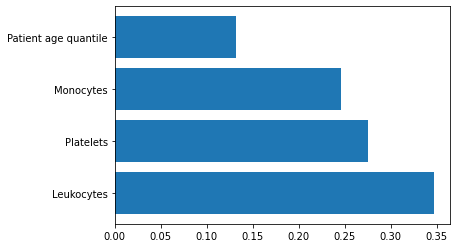

In [11]:
print_result(result)